# Hands-on: Estátisticas de segunda ordem: LCR e AFD

### Objetivos
* Gerar um sinal no domínio do tempo a partir de um filtro de 3ª ordem;
* Encontrar LCR e AFD simulado;
* Calcular LCR e AFD teórico.



## Parte 1: Gerar sinal no domínio do tempo

Vamos escrever um código para criação de um sinal sintético, para isso será necessário entrar com alguns parâmetros e criar um filtro de terceira ordem, que represetará nosso canal. No final do código será plotado a autocorrelação de $f/f_d$, sendo $f$ as frequências do range da simulação e $f/f_d$ a frequência Doppler.

**Passo 1:** criar filtro de 3ª ordem (...)

In [97]:
%% Parameters
fd=100;                               % frequency doppler
ts=1e-3;
t=[0:ts:0.1-ts];
N=length(t);                          % 2M+1 complex Gaussian random variables
M=floor((N-1)/2);   
f0=fd/M;
ind=f0;                               % frequency index
fmax=1e3;                             % maximum simulation frequency
fmin=-fmax;                           % minimum simulation frequency
fr=[fmin:ind:fmax];                   % frequency range for simulation
zeta=0.175;                           % Underdamp  value for zeta
w0=2*pi*fd/1.2;                       % Natural angular frequency
%% Third order filter
% Coefficients
a=w0^3;
b=(2*zeta*w0)+w0;
c=(2*zeta*(w0^2))+(w0^2);
%% building third order Filter in s-domain z-domain w-domain and f-domain
syms f s w;                               % define symbols
tf_s=tf(a,[1 b c a]);                     % 3rd order tf in S domain
tf_z=c2d(tf_s,ts,'tustin');               % tustin: bilinear transformation
h_s=(a/((s^3)+(b*(s^2))+(c*s)+a));        % 3rd order filter in S Dommain
h_W=subs(h_s,s,1i*w);                     % 3rd order filter in w Dommain
h_f=subs(h_W,w,(2*pi*f));                 % 3rd order filter in f Dommain
%%  AutoCorrelation 
hv=subs(h_f,f,fr);                         % filter gain for each frequency
hv_double=double(hv);                      % convert gains into double 
Autocorr=xcorr(hv_double);                 % Autocorrelation
Autocorr=real(Autocorr*(1/max(Autocorr)));  % normalize AutoCorr
%% choose the values from AutoCorrelation to plot
L=ceil(length(Autocorr)/4);           
AutocorrPlot=Autocorr(L:end-L+1);  % remove the first and fourth quarters
%% plot autcorrelation at positive side
L2=ceil(length(AutocorrPlot)/2);            
AutocorrPlot_P=AutocorrPlot(L2:end);        % Positive side of autocorr.
fr_P=fr(L2:end);                            % Positive frequencies

%% Impulse response of Digital Filter (channel)
[numZ denZ ts]=tfdata(tf_z,'v');
[h,n] = impz(numZ,denZ);
%% find n0 : at this point h(n) become negligible
a=abs((hv_double).^2);
[pks,locs] = findpeaks(h);
nv=0.01;                  % negligible value  as a percentage of maximum value
b=find(pks>=(nv*max(pks)));
peak_no=min(pks(b));
n0=max(locs(b));
%% normalizing the filter H(Z)
numZ_N=numZ./sqrt(sum(h.^2));      % normalize numerator of H(z)
tf_Z_N=tf(numZ_N,denZ,ts);

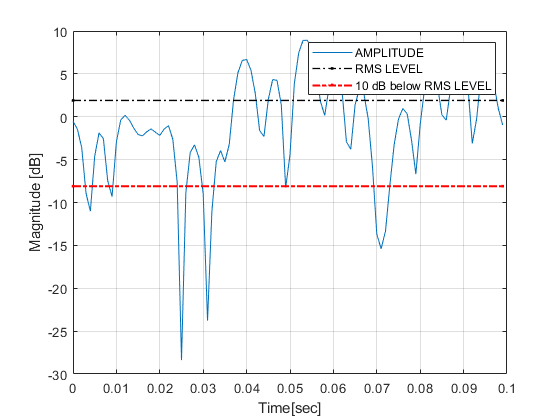

In [91]:
%% Generating an input signal with unit power => (power_db = 0)
% Ip is vector (n0 ,1) , simulation time:T=0.1 sec
IP_no=(1/(sqrt(2))).*(randn(1,n0)+(1j*randn(1,n0)));
IP_T=(1/(sqrt(2))).*(randn(1,length(t))+(1j*randn(1,length(t))));
IP=[IP_no IP_T];                      % first n0 bits for transient response
% Output from filter
Y=filter(numZ_N,denZ,IP);              % output from filter
Y_T=Y(n0+1:end);                       % output after removing transients
% Output in DB
Y_T_db=20.*log10(abs(Y_T));        % output when length of input=T  in dB
% root mean square value of input signals
rms_Y_T=rms(abs(Y_T));                  % rms of output length = T
rms_Y_T_db=20.*log10(abs(rms_Y_T));     % rms of output length = T in dB
ten_dB_below=rms_Y_T_db-10;
%% plotting output from filters
figure
plot(t,Y_T_db)
hold on
plot([t(1) t(end)],[rms_Y_T_db rms_Y_T_db],'.-.black','linewidth',1)
plot([t(1) t(end)],[ten_dB_below ten_dB_below],'.-.r','linewidth',1.5)
grid
legend('AMPLITUDE','RMS LEVEL','10 dB below RMS LEVEL')
xlabel('Time[sec]');
ylabel('Magnitude [dB]');

## Parte 2: Encontrar LCR e AFD 

A caracterização do desvanecimento de pequena escala pode ser feita por estatística de segunda ordem. Duas importantes estatísticas são comumente utilizadas para caracterizar o efeito Doppler nos canais móveis. A primeira é a taxa de cruzamento do sinal (LCR - *Level Crossing Rate*) que corresponde à frequência em que a potência do sinal cruza um determinado liminar no sentido positivo. Já a segunda estatística é o tempo que sinal permanece abaixo de um determinado limiar (AFD - *Average Fade Duration*) definido como o tempo médio que o sinal fica abaixo de um limiar estabelecido. Veremos a seguir como é calculado essas duas métricas.

**Passo 1:** Para calcular LCR e AFD simulado, crie a função **Cross_N_PD.m**. Essa função vai receber o vetor ***x*** correspondente ao sinal, o limiar ***L*** e o tempo de amostragem ***ts***, retornando o número de cruzamento no sentido positivo *CN_PD*, as localizaçãos do cruzamentos ***CPV***, o ***AFD*** e, por fim, o tempo ***FT*** que o sinal permanece abaixo de ***L***.
1. Criar vetor ***b*** que será responsável por indicar os pontos abaixo do limiar ***L***, sendo 1 quando ***x*** < ***L***, e 0 para o contrário.
2. Criar o vetor ***c*** é responsável por contabilizar os cruzamentos. Inicialmente ***c*** = ***b***, porém é feito uma varredura no sentido positivo que ao indentificar em ***b*** uma sequência de 1, entende que não há cruzamento e, portando, ***c*** naquele ponto passa a ser 0. Caso não seja identificado essa sequência, ***c*** permanece sendo 1, indicando o cruzamento.

In [92]:
%%file Cross_N_PD.m
% this function takes four variables:- 
%    x: vector of real values
%    L: Level of crossing
%    ts: sampling time
% this function returns four variables:-
%    CN_PD: crossing number in Positive direction
%    CPV  : vector denoting the location of crossing at Positive direction
%    LCR  : Level Crossing Rate
%    AFD  : Average fade duration
%    FT   : Fraction of time that signal goes below L
function  [CN_PD CPV LCR AFD FT]= Cross_N_PD(x,L,ts)
AFD=0;
b=double((x<L));                
c=b;                            
for k=length(b):-1:2            
    if b(k)==1 & b(k-1)==1        
       c(k-1)=0;                
    end
end
CN_PD = sum(c);                  
CPV=c;
LCR=CN_PD/(ts*length(x));
AFD=(sum(b)).*ts./CN_PD;
FT=AFD.*CN_PD;

Created file 'C:\Users\julie\OneDrive\Área de Trabalho\MESTRADO - PPGEEC\DISCIPLINAS\RADIOPROPAGAÇÃO\doppler\codigo_matlab\Cross_N_PD.m'.


Tendo posse do nosso sinal gerado ***Y_T_db***, do limiar ***ten_dB_below*** e do tempo de amostragem ***ts***, veremos os resultados obtidos pela função **Cross_N_PD.m**.

In [93]:
%% exact crossing and exact average fade duration in this run
[CN_PD_s CPV LCR_s AFD_s FT]= Cross_N_PD(Y_T_db,ten_dB_below,ts);

disp('Simulation Result: Number of Crossing per 0.1 sec "PD: Positive Direction"')
CN_PD_s                       % simulation crossing number during 0.1 sec

disp('Simulation Result: Level Crossing Rate')
LCR_s

disp('Simulation Result: Average Fade Duration')
AFD_s

disp('Simulation Result: Fraction of time when signal goes below specific level')
disp('Total duration of fade per second')
FT

Simulation Result: Number of Crossing per 0.1 sec "PD: Positive Direction"

CN_PD_s =

     6

Simulation Result: Level Crossing Rate

LCR_s =

    60

Simulation Result: Average Fade Duration

AFD_s =

    0.0020

Simulation Result: Fraction of time when signal goes below specific level
Total duration of fade per second

FT =

    0.0120




Para visualizar os pontos de cruzamento com mais detalhes, vamos plotar novamente o sinal gerado e o limiar definido.

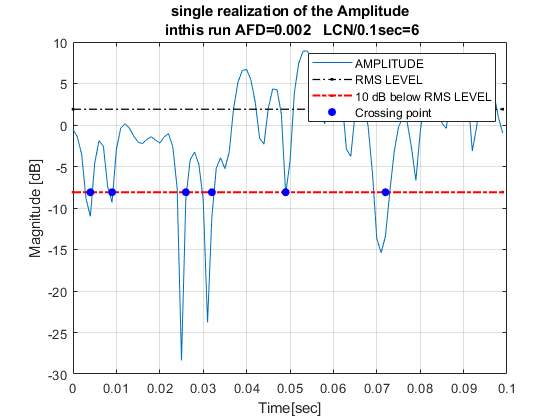

In [94]:
%% plotting output from filters
figure
plot(t,Y_T_db)
hold on
plot([t(1) t(end)],[rms_Y_T_db rms_Y_T_db],'.-.black','linewidth',1)
plot([t(1) t(end)],[ten_dB_below ten_dB_below],'.-.r','linewidth',1.5)
grid
title({'single realization of the Amplitude';strcat(' inthis run AFD=',num2str(AFD_s),'   LCN/0.1sec=',num2str(CN_PD_s))})
xlabel('Time[sec]');
ylabel('Magnitude [dB]');
%% plot filled circles at crossing points in the positive direction
loc=find(CPV);
scatter(t(loc),ten_dB_below.*ones(1,length(loc)),'filled','blue')
legend('AMPLITUDE','RMS LEVEL','10 dB below RMS LEVEL','Crossing point')

**Passo 2:** Para calcular LCR e AFD teórico, faremos a aplicação das fórmulas teóricas.
1. É importante saber que as fórmulas teóricas de LCR e AFD mudam em função de modelos clássicos de canais
sem fio (Rayleigh, Rice, Nakagami e Weibull). No nosso caso, vamos seguir a modelo de Rayleigh, que é dado por: 

<center> $LCR_{Rayleigh}(\rho) = \sqrt{2 \pi} f_d \rho \exp(-\rho^2)$
    
<center> $AFD_{Rayleigh}(\rho) = \frac{\exp(\rho^2)-1}{\sqrt{2 \pi} f_d \rho}$

In [95]:
%% Expectation of Level Crossing Rate in Ts time and Average Fade Duration
RowdB=ten_dB_below-rms_Y_T_db;
Row=10.^(RowdB/20);
disp('Theoretical LCR "Level Crossing Rate" ')
LCR=(sqrt(2*pi).*fd.*Row.*exp(-(Row.^2)))   % Expected level Crossing rate per second
disp('Theoretical AFD "Average Fade Duration" ')
AFD=(exp(Row.^2)-1)/((sqrt(2*pi)).*fd.*Row)

Theoretical LCR "Level Crossing Rate" 

LCR =

   71.7233

Theoretical AFD "Average Fade Duration" 

AFD =

    0.0013




### Referências

* MOHAMMED ELAMASSIE (2022). Level crossing rate (LCR) and average fade duration (AFD). Disponível em: https://www.mathworks.com/matlabcentral/fileexchange/54750-level-crossing-rate-lcr-and-average-fade-duration-afd. MATLAB Central File Exchange.
* ABDI, Ali, et al. Comparison of the level crossing rate and average fade duration of Rayleigh, Rice and Nakagami fading models with mobile channel data. In: Vehicular Technology Conference Fall 2000. IEEE VTS Fall VTC2000. 52nd Vehicular Technology Conference (Cat. No. 00CH37152). IEEE, 2000. p. 1850-1857

#### Leitura complementar: AFD e LCR para os demais modelos
* FRAIDENRAICH, Gustavo; YACOUB, Michel D.; SANTOS FILHO, José Cândido S. Second-order statistics of maximal-ratio and equal-gain combining in Weibull fading. IEEE communications letters, 2005, 9.6: 499-501.
* YACOUB, Michel Daoud; DA SILVA, Cláudio Rafael Cunha Monteiro; BAUTISTA, JE Vargas. Second-order statistics for diversity-combining techniques in Nakagami-fading channels. IEEE Transactions on Vehicular Technology, 2001, 50.6: 1464-1470.
* RICE, Stephen O. Mathematical analysis of random noise. The Bell System Technical Journal, 1944, 23.3: 282-332.